In [1]:
import os
from PIL import Image
import numpy as np

# Corrected Paths
image_dir = r'C:\Users\ALI\Documents\led_sensing\dataset\image_mask_data\Image'
mask_dir  = r'C:\Users\ALI\Documents\led_sensing\dataset\image_mask_data\Mask'

# Get sorted file lists to align images and masks
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])
mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.png')])

X = []
Y = []

# Load each image-mask pair
for img_file, mask_file in zip(image_files, mask_files):
    # Load image
    img_path = os.path.join(image_dir, img_file)
    img = Image.open(img_path).convert('L').resize((25, 25))
    img_array = np.array(img, dtype=np.float32) / 255.0
    img_array = np.expand_dims(img_array, axis=-1)

    # Load corresponding mask


In [2]:
print("Number of loaded images:", len(X))
print("Shape of X array:", X.shape if len(X) > 0 else "X is empty")
print("Example filenames:", image_files[:3])



Number of loaded images: 0
Shape of X array: X is empty
Example filenames: ['LED_Matrix_2025_02_24_22_52_37_1.png', 'LED_Matrix_2025_02_24_22_52_37_2.png', 'LED_Matrix_2025_02_24_22_52_37_3.png']


In [3]:
print("Image files:", len(image_files))
print("Mask files:", len(mask_files))
print("Example image:", image_files[0])
print("Example mask :", mask_files[0])


Image files: 822
Mask files: 822
Example image: LED_Matrix_2025_02_24_22_52_37_1.png
Example mask : LED_Matrix_2025_02_24_22_52_37_1.png


In [4]:
X = []
Y = []

for img_file, mask_file in zip(image_files, mask_files):
    try:
        # Full paths
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)

        # Load and preprocess image
        img = Image.open(img_path).convert('L').resize((25, 25))
        img_array = np.array(img, dtype=np.float32) / 255.0
        img_array = np.expand_dims(img_array, axis=-1)

        # Load and preprocess mask
        mask = Image.open(mask_path).convert('L').resize((25, 25))
        mask_array = np.array(mask, dtype=np.float32) / 255.0
        mask_array = np.expand_dims(mask_array, axis=-1)

        # Append to datasets
        X.append(img_array)
        Y.append(mask_array)

    except Exception as e:
        print(f"Error processing {img_file} or {mask_file}: {e}")


In [5]:
import numpy as np
from sklearn.model_selection import train_test_split

# Convert to numpy arrays
X = np.array(X)
Y = np.array(Y)

# Split dataset: 80% train / 20% test
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

print("Train:", X_train.shape, Y_train.shape)
print("Test :", X_test.shape, Y_test.shape)


Train: (657, 25, 25, 1) (657, 25, 25, 1)
Test : (165, 25, 25, 1) (165, 25, 25, 1)


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score

# --- Helper Functions ---

def plot_sample_predictions(X, y_true, y_pred, num_samples=3, threshold=0.5):
    plt.figure(figsize=(15, 5*num_samples))
    X = X.numpy() if tf.is_tensor(X) else X
    y_true = y_true.numpy() if tf.is_tensor(y_true) else y_true
    y_pred = y_pred.numpy() if tf.is_tensor(y_pred) else y_pred

    for i in range(num_samples):
        idx = np.random.randint(0, len(X))
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(X[idx].squeeze(), cmap='viridis')
        plt.title(f'Sample {idx+1} - Input')
        plt.colorbar()

        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(y_true[idx].squeeze(), cmap='binary', vmin=0, vmax=1)
        plt.title('True Label')

        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow((y_pred[idx] > threshold).squeeze(), cmap='binary', vmin=0, vmax=1)
        plt.title(f'Prediction (Threshold={threshold})')
    plt.tight_layout()
    plt.show()

def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(25, 25, 1)),
        tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.UpSampling2D(),  # Upsample back to 13x13
        tf.keras.layers.UpSampling2D(),  # Upsample again to 25x25
        tf.keras.layers.Conv2D(1, 1, activation='sigmoid', padding='same')  # Match mask shape
    ])
    return model


def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fn(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
        focal_loss = -alpha_t * tf.pow(1.0 - p_t, gamma) * tf.math.log(p_t)
        return tf.reduce_mean(focal_loss)
    return focal_loss_fn

def iou_metric(y_true, y_pred, threshold=0.5):
    y_pred = tf.cast(y_pred > threshold, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + 1e-7) / (union + 1e-7)

def plot_history(history, title):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.tight_layout()
    plt.show()

def find_optimal_threshold(y_true, y_pred_proba):
    y_true_np = y_true.numpy() if tf.is_tensor(y_true) else y_true
    y_pred_np = y_pred_proba.numpy() if tf.is_tensor(y_pred_proba) else y_pred_proba
    thresholds = np.linspace(0.1, 0.9, 50)
    f1_scores = []

    for thresh in thresholds:
        y_pred = (y_pred_np > thresh).astype(np.float32)
        f1 = f1_score(y_true_np.reshape(-1), y_pred.reshape(-1))
        f1_scores.append(f1)

    best_threshold = thresholds[np.argmax(f1_scores)]
    plt.figure(figsize=(10, 5))
    plt.plot(thresholds, f1_scores, 'b-')
    plt.axvline(x=best_threshold, color='r', linestyle='--')
    plt.title(f'Optimal Threshold: {best_threshold:.3f}')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.grid(True)
    plt.show()
    return best_threshold


In [7]:
import os
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split

image_dir = r'C:\Users\ALI\Documents\led_sensing\dataset\image_mask_data\Image'
mask_dir  = r'C:\Users\ALI\Documents\led_sensing\dataset\image_mask_data\Mask'

image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])
mask_files  = sorted([f for f in os.listdir(mask_dir) if f.endswith('.png')])

X, Y = [], []

for img_file, mask_file in zip(image_files, mask_files):
    img = Image.open(os.path.join(image_dir, img_file)).convert('L').resize((25, 25))
    mask = Image.open(os.path.join(mask_dir, mask_file)).convert('L').resize((25, 25))

    img_arr = np.expand_dims(np.array(img, dtype=np.float32) / 255.0, axis=-1)
    mask_arr = np.expand_dims(np.array(mask, dtype=np.float32) / 255.0, axis=-1)

    X.append(img_arr)
    Y.append(mask_arr)

X = np.array(X)
Y = np.array(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [8]:
X_train_np = X_train.astype('float32')
Y_train_np = Y_train.astype('float32')
X_test_np  = X_test.astype('float32')
Y_test_np  = Y_test.astype('float32')


In [9]:
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(25, 25, 1)),
        tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.UpSampling2D(),
        tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.UpSampling2D(),
        tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.ZeroPadding2D(padding=((1, 0), (1, 0))),  # To get 25x25
        tf.keras.layers.Conv2D(1, 1, activation='sigmoid', padding='same')
    ])
    return model


In [10]:
model_focal = create_model()

def focal_loss(gamma=2.0, alpha=0.25):
    def loss_fn(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
        focal_loss = -alpha_t * tf.pow(1.0 - p_t, gamma) * tf.math.log(p_t)
        return tf.reduce_mean(focal_loss)
    return loss_fn

model_focal.compile(
    optimizer='adam',
    loss=focal_loss(),
    metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_focal = model_focal.fit(
    X_train_np, Y_train_np,
    epochs=50,
    batch_size=16,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.7896 - loss: 0.0745 - precision: 0.0732 - recall: 0.1543 - val_accuracy: 0.9214 - val_loss: 0.0310 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9255 - loss: 0.0302 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9214 - val_loss: 0.0289 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9248 - loss: 0.0270 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9214 - val_loss: 0.0285 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9248 - loss: 0.0262 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9214 - val_loss: 0.0284 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9244 - loss: 0.0261 - precision: 0.0000e+00

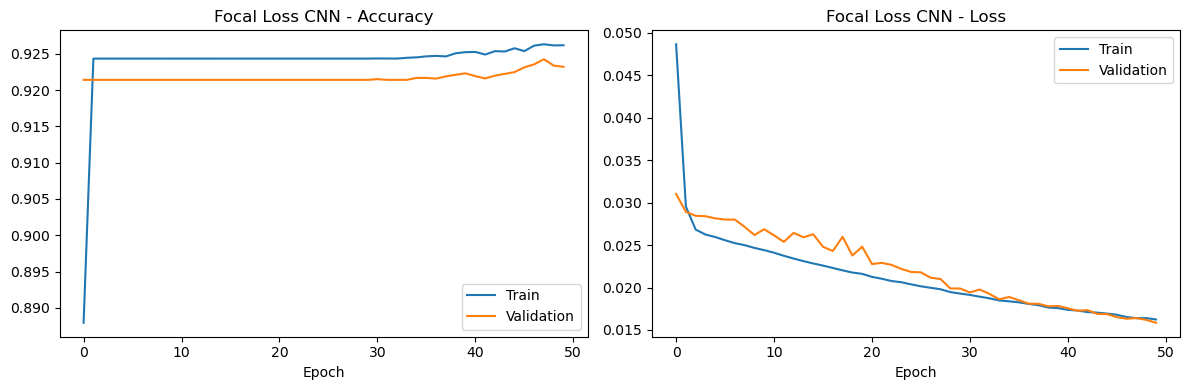

In [11]:
def plot_history(history, title="Model"):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_history(history_focal, "Focal Loss CNN")



6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


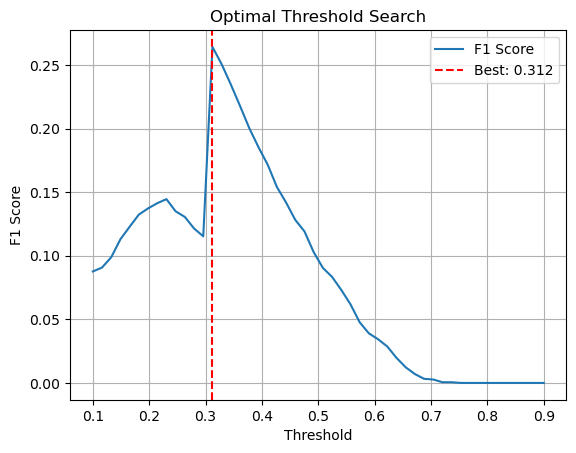

Best Threshold: 0.312


In [13]:
from sklearn.metrics import f1_score

def find_optimal_threshold(y_true, y_pred):
    # Ensure both are numpy arrays
    y_true = y_true.astype(np.uint8)         # force to binary (0/1)
    y_pred = y_pred.astype(np.float32)       # keep as float for thresholding

    thresholds = np.linspace(0.1, 0.9, 50)
    f1_scores = []

    for t in thresholds:
        y_pred_bin = (y_pred > t).astype(np.uint8)
        f1 = f1_score(y_true.reshape(-1), y_pred_bin.reshape(-1))
        f1_scores.append(f1)

    best_t = thresholds[np.argmax(f1_scores)]

    plt.plot(thresholds, f1_scores, label='F1 Score')
    plt.axvline(best_t, color='red', linestyle='--', label=f'Best: {best_t:.3f}')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.title('Optimal Threshold Search')
    plt.legend()
    plt.grid(True)
    plt.show()

    return best_t
# Get model predictions on test data
y_pred_proba = model_focal.predict(X_test_np)  # This gives probabilities (0 to 1)
best_threshold = find_optimal_threshold(Y_test_np, y_pred_proba)
print(f"Best Threshold: {best_threshold:.3f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


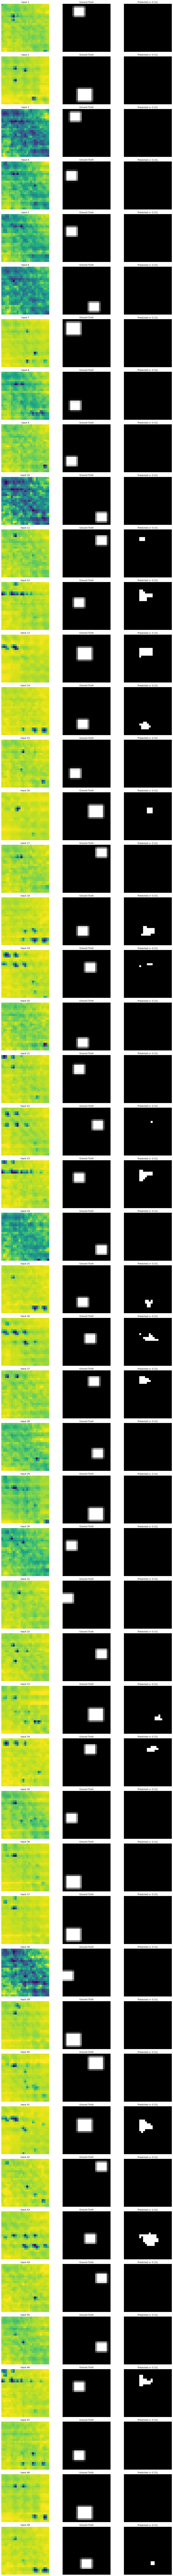

In [14]:
import matplotlib.pyplot as plt

def visualize_predictions_range(model, X, Y_true, start=0, end=5, threshold=0.5):
    """
    Visualizes predictions for samples in a given index range [start, end).
    Each row: Input | Ground Truth | Predicted Mask
    """
    y_pred = model.predict(X[start:end])
    
    num_samples = end - start
    plt.figure(figsize=(15, 4 * num_samples))
    
    for i in range(num_samples):
        idx = start + i
        
        # Original image
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(X[idx].squeeze(), cmap='viridis')
        plt.title(f'Input {idx}')
        plt.axis('off')

        # Ground truth
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(Y_true[idx].squeeze(), cmap='gray')
        plt.title('Ground Truth')
        plt.axis('off')

        # Prediction
        plt.subplot(num_samples, 3, i * 3 + 3)
        pred_mask = (y_pred[i] > threshold).squeeze()
        plt.imshow(pred_mask, cmap='gray')
        plt.title(f'Predicted (> {threshold:.2f})')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_predictions_range(model_focal, X_test_np, Y_test_np, start=1, end=50, threshold=best_threshold)


In [16]:
from sklearn.metrics import recall_score

# Ensure both arrays are strictly binary (0 or 1)
y_true_flat = (Y_test_np > 0.5).astype(np.uint8).flatten()
y_pred_flat = (y_pred_proba > best_threshold).astype(np.uint8).flatten()

# Calculate Recall
recall = recall_score(y_true_flat, y_pred_flat)
print(f"Recall Score: {recall:.4f}")


Recall Score: 0.1652
